In [0]:
!pip install tensorflow-gpu==2.0.0
!pip install gym

     |████████████████████████████████| 380.8MB 42kB/s 
     |████████████████████████████████| 3.8MB 64.6MB/s 
     |████████████████████████████████| 450kB 72.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=488412d10125c9e88a1dcc2625c99a23336e82bc870e1e34fd88a7446eb7098f
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstall

In [0]:
# Imports
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from IPython import display
import cv2
import time
import gc

import gym
import tensorflow as tf

In [0]:
#test tensorflow-gpu and data storage.
print(tf.test.gpu_device_name())
print(np.genfromtxt("sample_data/mnist_test.csv", delimiter=",").shape)
tf.random.set_seed(27)
tf.compat.v1.reset_default_graph()

/device:GPU:0
(10000, 785)


In [0]:
# Display functions because Env.render() doesn't work on colab.
# Inspired by https://stackoverflow.com/questions/40195740/how-to-run-openai-gym-render-over-a-server, Nathan.
# Reworked by M.Yao, A.Bruinsma, S.Zeng
def multi_render(env):
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
def end_render(env):
    plt.imshow(env.render(mode='rgb_array'))
    plt.axis("off")
# Compress the image
def compress_img(img):
    img = img[::2,::2,:] # Shrink by factor of 2
    img = np.mean(img, axis=2) # Convert to gray scale
    ret,img=cv2.threshold(img,0,1,cv2.THRESH_BINARY) # Binarization
    img = np.array(img).astype(np.uint8)
    # Note that we also accomplished normalization here as setting marked pixel's value to 1.
    return img
# Build a BreakOut env and play.

def BreakOut_random(): 
    env = gym.make('BreakoutDeterministic-v4')
    print("action options = ", env.action_space.n)
    frame = env.reset() # initialize the env
    done = False
    i = 1
    while not done:
        """
        if i == 0:
            img = plt.imshow(env.render(mode='rgb_array'))
            plt.axis("off")
        if i%32 == 0:
            multi_render()
        """
        frame, reward, done, info = env.step(env.action_space.sample())
        i+=1
    end_render(env)
    return i
def sign_reward(reward):
    return 1 if reward>0 else -1 if reward<0 else 0

action options =  4


139

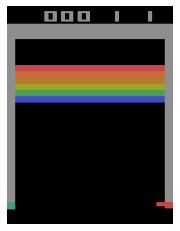

In [0]:
BreakOut_random()

In [0]:
def NN_model():
    # Frames input contains 4 frames of breakout game and the shape of each frame is 105*80, we set 4 as the number of channels.
    frames = tf.keras.Input(shape=(105,80,4),name = "frames")
    # Actions input contains a one_hot array representing the action we take, for example: arrary([0,1,0,0])
    # This input will be used as a marker to covert Q(s,a{i-n}) to Q(s,a_i) = value and 3 zeros.
    actions = tf.keras.Input(shape=(4,), name = "actions")
    Conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=[8, 8], strides=4,\
                                    kernel_initializer='normal', padding="valid", activation="relu", name = "Conv1")(frames)
    Bnorm1 = tf.keras.layers.BatchNormalization(axis=-1)(Conv1)
    Conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=[4, 4], strides=2,\
                                    kernel_initializer='normal', padding="valid", activation="relu", name = "Conv2")(Bnorm1)
    Bnorm2 = tf.keras.layers.BatchNormalization(axis=-1)(Conv2)
    Conv3 = tf.keras.layers.Conv2D(filters=32, kernel_size=[3, 3], strides=1,\
                                    kernel_initializer='normal', padding="valid", activation="relu", name = "Conv3")(Bnorm2)
    Flatten = tf.keras.layers.Flatten(name = "Flatten")(Conv3)
    Dense = tf.keras.layers.Dense(256, activation='relu', name= "Dense")(Flatten)
    QQQQlayer = tf.keras.layers.Dense(4,name = "QQQQ")(Dense)
    Qlayer = tf.keras.layers.multiply([QQQQlayer,actions],name = "0Q00")
    model = tf.keras.models.Model(inputs=[frames, actions], outputs=Qlayer)
    model.summary()
    model.compile(loss=tf.keras.losses.Huber(delta=1.5), optimizer='adam',metrics=['mae','mse'])
    return model

In [0]:
def fit_model(model,gamma, states, actions, reward ,states_next):
    actions_next =np.ones((len(states),4))
    Q_next = model.predict([states_next,actions_next]) # filter all possible Q_next by setting mask to [1,1,1,1]
    Q_target = reward + gamma * np.max(Q_next, axis=1) # Calculate the target Q value with Q's funtion.
    hs_1time = model.fit([states, actions], actions * Q_target[:, None],batch_size=len(states), epochs = 1, verbose=0) # fit NN
    # Save the mse to monitor if the NN is learning.
    hs.append(hs_1time.history["mse"])

In [0]:
def breakout_4frames(epsilon,n_frame):
    """
    epsilon : epsilon greedy policy
    n_frame: due to the delay of reward in breakout game, we define a difference between a state and its next.
             For exmaple, we assume if an action is taken and hitted the ball, it needs 50 frames to reach the brick and get a reward.
    """
    env = gym.make('BreakoutDeterministic-v4')
    #print("action options = ", env.action_space.n)
    frame = env.reset() # initialize the env
    done = False
    score = 0
    i = 1
    data_Y = np.array([]).astype(np.uint8)
    data_actions = np.array([]).astype(np.uint8)
    state = np.zeros((105,80,4))
    frame = compress_img(frame)
    state[:,:,0] = frame
    start_time = time.time()
    while not done:
        if i < 4:
            # if we dont have a state yet, play randomly.
            action = env.action_space.sample()
            frame, reward, done, info = env.step(action)
            frame = compress_img(frame)
            state[:,:,i] = frame
            # Once we start to have state, we save this state.
            if i == 3:
                #Reset states for every new game.
                data_X =  np.expand_dims(state, axis=0)
        else:
            # we save action taken on that state, reward we gain.
            
            action = get_action(state,epsilon)
            data_actions = np.append(data_actions,action)
            frame, reward, done, info = env.step(action)
            data_Y = np.append(data_Y,sign_reward(reward))
            score += reward
            # update the state
            frame1 = state[:,:,1]
            frame2 = state[:,:,2]
            frame3 = state[:,:,3]
            frame = compress_img(frame)
            state_next = np.stack((frame1,frame2,frame3,frame),axis=-1)
            # append new state to data_X
            data_X = np.append(data_X,np.expand_dims(state_next, axis=0),axis = 0)
            
            # Once we have 32 states and 32 next states, train network.
            # The difference between 2 states is (n_frame) frames
            if len(data_X) == (32+n_frame):
                fit_model(model,0.6,data_X[:0-n_frame],tf.one_hot(data_actions[:0-n_frame+1], depth = 4,dtype = tf.int8), data_Y[n_frame-1:],data_X[n_frame:])

                # Clear the RAM
                del data_X
                gc.collect()
                # Rest the states
                data_X = np.expand_dims(state_next, axis=0)
                # Reset reward and action arrays.
                data_Y = np.array([]).astype(np.uint8)
                data_actions = np.array([]).astype(np.uint8)
            
            """
            # train the network every time we have a new state.
            fit_model(model,0.99,np.expand_dims(state, axis=0),np.expand_dims(tf.one_hot(action, depth = 4,dtype = tf.int8),axis=0),\
                      sign_reward(reward), np.expand_dims(state_next,axis=0))
            if (i-4) % 200 == 0:
                print(i-4,"times training are done")
            """
            state = state_next
        if time.time()- start_time > 600:
            break
        i += 1
    #print("-------play one game------")
    #print("socre of this game :",score)
    return score



def get_action(state,epsilon):
    if np.random.rand() < epsilon :
        return np.random.randint(4)
    else:
        try:
            state = np.expand_dims(state,axis=0)
            QQQQ = model.predict([state,np.expand_dims(np.ones(4),axis = 0)])
            action = np.argmax(QQQQ)
        except:
            raise TypeError("Unable to predict")
            #action = np.random.randint(4)
        return action

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
frames (InputLayer)             [(None, 105, 80, 4)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 25, 19, 16)   4112        frames[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 25, 19, 16)   64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 11, 8, 32)    8224        batch_normalization[0][0]        
______________________________________________________________________________________________

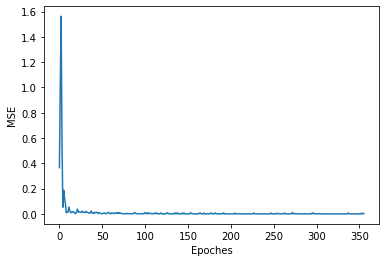

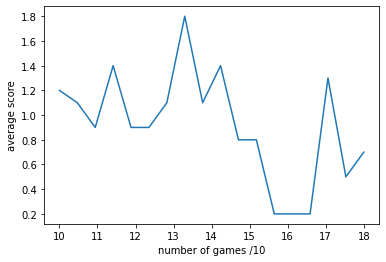

In [0]:
tf.compat.v1.reset_default_graph()
model = NN_model()
start_time2 = time.time()
scores_n = []
scores=[]
avg_scores = []
hs = []
for j in range(1000000):
    #epsilon-greedy with epsilon annealed linearly from 1 to 0.1 over 1000000 iterations, and fixed at 0.1 thereafter.
    epsilon = max(1 - j/200, 0.1)
    score = breakout_4frames(epsilon,n_frame=50)
    scores.append(score)
    n = 10
    if (j+1) % n  == 0:
        avg_score = np.mean(scores)
        print("==============================================")
        print("++++++++++++",j+1," games are done +++++++++++")
        print("average score of ",n, " games = ", avg_score)
        print("==============================================")
        avg_scores.append(avg_score)
        scores=[]
    if time.time()-start_time2 > 1200:
        break
# Plot the loss of function
plt.plot(np.linspace(0,len(hs),(len(hs))),hs)
plt.xlabel("Epoches")
plt.ylabel("MSE")
plt.savefig("breakout_loss.pdf")
plt.show()

# Plot the average score of every 10 games
plt.plot(np.linspace(10,len(avg_scores),len(avg_scores)),avg_scores)
plt.xlabel("number of games /10")
plt.ylabel("average score")
plt.savefig("BO_average_score.pdf")
plt.show()

In [0]:
import sys
# A function that copied for https://stackoverflow.com/a/1094933/1870254, used for monitoring the storage.
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                           _ii:  3.6 KiB
                           _i8:  3.6 KiB
                            hs:  3.2 KiB
                           _i6:  1.7 KiB
                           _i4:  1.2 KiB
                            _i:  1.2 KiB
                           _i9:  1.2 KiB
                          _iii:  594.0 B
                           _i7:  594.0 B
                          _i10:  587.0 B
